In [367]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
# pip install cvxopt
# pip install numdifftools
# pip install scikit-optimize

In [369]:
from skopt import benchmarks as bench

In [370]:
import os
import sys
sys.path.append('..')

import numpy as np
from numpy import linalg
from scipy.optimize import linprog, minimize_scalar
from scipy.stats import norm, chi2
from scipy.linalg import expm
from scipy.integrate import quad

import numdifftools as nd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import lib.LB_convex_optimizer as LB
from lib.functions_plots import PlotTrajectory, PlotConvergence, PlotConvergenceShaded


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

import pickle

In [371]:
import GPy
from safeopt import SafeOpt, SafeOptSwarm
from safeopt import linearly_spaced_combinations, plot_3d_gp
from lib.safeopt_run import run_SafeOpt

# Comparison experiments

In [381]:
def run_exp_SafeOpt(f, h, 
                    d, m,
                    experiments_num = 5, 
                    n_iters = 100,  
                    x00 = np.zeros(2), 
                    x_opt =  np.ones(2) / 2**0.5,  
                    sigma = 0.001,
                    bnd = 1):

    errors = []
    cons = []
    for i in range(experiments_num):
        x_traj, errors_so, cons_so, gp = run_SafeOpt(n_iters, 
                                                     f, h, 
                                                     x00, x_opt, 
                                                     d, m, 
                                                     sigma, bnd)
        ################ remove if want to run outside of the notebook ##########
#         plt.show()
#         plt.plot(x_traj[:,0], x_traj[:,1], "o")
#         plt.plot(x_traj[-1,0], x_traj[-1,1], "ro")
#         plt.plot(x_opt[0], x_opt[1], "g*")
#         x_size = x_traj.shape[0]
#         plt.show()
        #########################################################################
        print("SafeOptRun finished")
        errors.append(errors_so)
        cons.append(cons_so)
    errors = np.array(errors)
    cons = np.array(cons)
    
    with open('../runs/SafeOpt_d' + str(d) + '.npy', 'wb') as file:
        np.save(file, errors)
        np.save(file, cons)
    
    return (errors, cons, gp)  

def run_exp_LB_SGD(f, h, d, m,
                   experiments_num = 5, 
                   n_iters = 100, 
                   n = 1, 
                   M0 = 0.5 / 2., 
                   Ms = 0. * np.ones(m), 
                   x00 = np.zeros(2), 
                   x_opt =  np.ones(2) / 2**0.5, 
                   sigma = 0.001, nu = 0.01, 
                   eta0 = 0.05, 
                   T = 3, 
                   factor = 0.85, 
                   init_std = 0.1 ):

    my_oracle = LB.Oracle(
        f = f,
        h = h, 
        sigma = sigma,
        hat_sigma = 0.01,
        delta = 0.01,
        m = m,
        d = d,
        nu = nu,
        zeroth_order = True,
        n = n)

    opt = LB.SafeLogBarrierOptimizer(
        x00 = x00,
        x0 = x00,
        M0 = M0,
        Ms = Ms,
        sigma = my_oracle.sigma,
        hat_sigma = my_oracle.hat_sigma,
        init_std = init_std,
        eta0 = eta0,
        oracle = my_oracle,
        f = f,
        h = h,
        d = d,
        m = m,
        reg = 0.0001,
        x_opt = x_opt,
        factor = factor,
        T = T,
        K = int(n_iters / T / 2. / n),
        experiments_num = experiments_num,
        mu = 0.,
        convex = True,
        random_init = True,
        no_break = True)

    opt.run_average_experiment()
    
    for i in range(experiments_num):
        opt.errors_total[i] = np.repeat(opt.errors_total[i], 2 * n)
        opt.constraints_total[i] = np.repeat(opt.constraints_total[i], 2 * n )
    
    errors = opt.errors_total
    constraints = opt.constraints_total
#     errors = np.array(opt.errors_total)
#     constraints = np.array(opt.constraints_total)
    
    with open('../runs/LB_SGD_d' + str(d) + '.npy', 'wb') as file:
        np.save(file, errors)
        np.save(file, constraints)

    return opt

## SafeOpt vs LB-SGD on QP

### d = 2

In [382]:
d = 2
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n_iters = d * 50
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001

# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d


In [383]:
(SO_errors2, SO_cons2, gp2) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


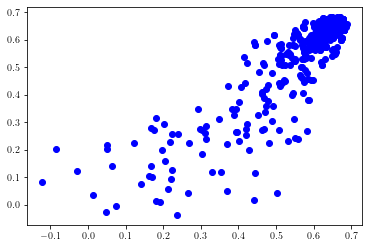

In [384]:
opt2 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma)

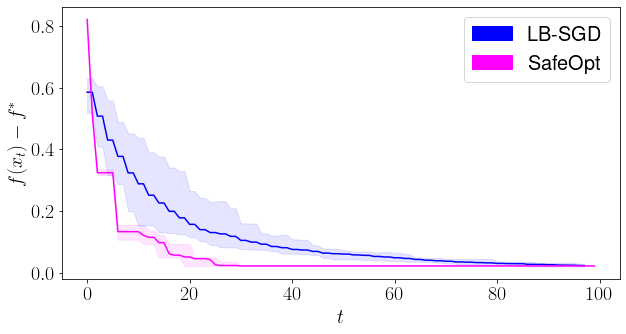

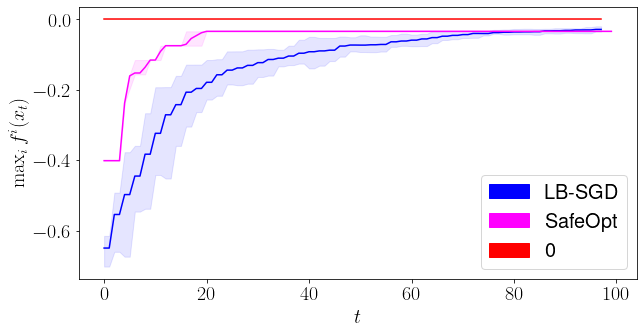

0

In [385]:
with open('../runs/SafeOpt_d' + str(d) + '.npy', 'rb') as file:
    SO_errors_d2 = np.load(file)
    SO_cons_d2 = np.load(file) 
with open('../runs/LB_SGD_d' + str(d) + '.npy', 'rb') as file:
    LB_errors_d2 = np.load(file)
    LB_cons_d2 = np.load(file) 
    
PlotConvergenceShaded([LB_errors_d2, SO_errors_d2], 
                      experiments_num, 
                      colors=['blue', 'magenta'], 
                      legends=['LB-SGD', 'SafeOpt' ],
                      figsize=(10, 5),
                      fname = "../runs/objective_QP_d2",  m = "accuracy")

shape = np.shape(opt2.constraints_total)

PlotConvergenceShaded([LB_cons_d2, SO_cons_d2, np.zeros(shape)], 
                      experiments_num, 
                      colors=['blue', 'magenta', 'red'], 
                      legends=['LB-SGD', 'SafeOpt','0'],
                      figsize=(10, 5),
                      fname = "../runs/constraints_QP_d2",  m = "constraints")

### d = 3

In [364]:
d = 3
m = 2 * d 
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n = int(d / 2)
n_iters = d * 60
x_opt = np.ones(d) / d**0.5
x00 = np.zeros(d)
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3
sigma = 0.001

# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
    return np.linalg.norm(x - xx, 2)**2 / 4. / d



In [361]:
(SO_errors3, SO_cons3, gp3) = run_exp_SafeOpt(f, h, d, m,
                                                experiments_num = experiments_num, 
                                                n_iters = n_iters,  
                                                x00 = x00, 
                                                x_opt =  x_opt,  
                                                sigma = sigma)

SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished
SafeOptRun finished


SafeOptRun finished
SafeOptRun finished


LB_SGD runs finished


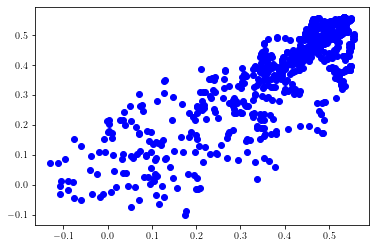

In [365]:
opt3 = run_exp_LB_SGD(f, h, d, m,
                       experiments_num = experiments_num, 
                       n_iters = n_iters,
                       n = n, 
                       M0 = M0, 
                       Ms = Ms, 
                       x00 = x00, 
                       x_opt = x_opt, 
                       sigma = sigma)

for i in range(experiments_num):
    opt3.errors_total[i] = np.repeat(opt3.errors_total[i], 2 * n)
    opt3.constraints_total[i] = np.repeat(opt3.constraints_total[i], 2 * n )

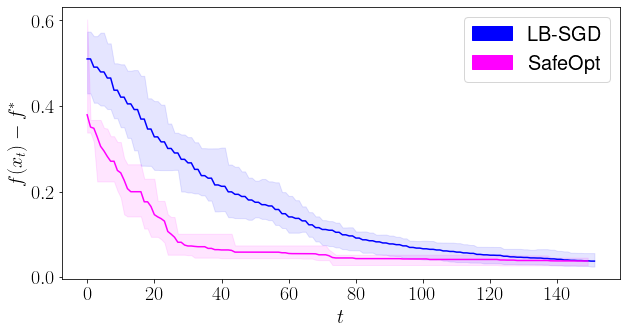

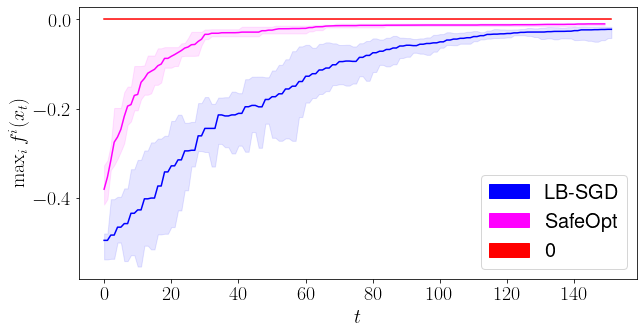

0

In [366]:
PlotConvergenceShaded([opt3.errors_total, SO_errors3], 
                      opt3.experiments_num, 
                      colors=['blue', 'magenta'], 
                      legends=['LB-SGD', 'SafeOpt' ],
                      figsize=(10, 5),
                      fname = "objective_QP_d3",  m = "accuracy")

shape = np.shape(opt3.constraints_total)

PlotConvergenceShaded([opt3.constraints_total, SO_cons3, np.zeros(shape)], 
                      opt3.experiments_num, 
                      colors=['blue', 'magenta', 'red'], 
                      legends=['LB-SGD', 'SafeOpt','0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d3",  m = "constraints")

# EVERYTHING BELOW IS NOT UPDATED (I save them to remember hyperparametersc parameters)

In [390]:
d = 3
m = 2 * d 
x0 = np.ones(d) * 0.2
x_opt =  np.ones(d) / d**0.5
# n = int(d / 2)
n = 1
experiments_num = 10

# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
#     xx[0] = 5.
    return np.linalg.norm(x - xx, 2)**2 / 4. / d 

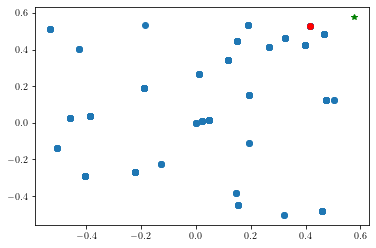

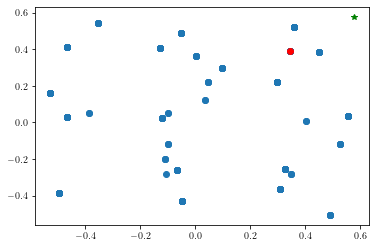

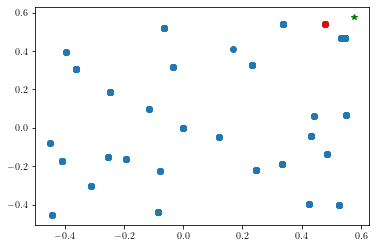

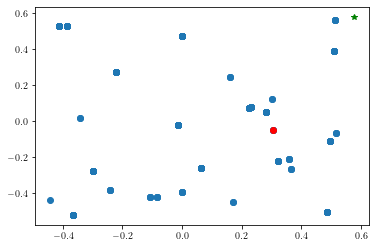

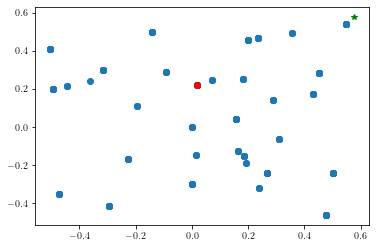

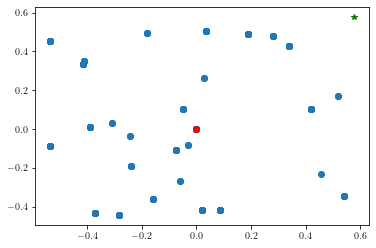

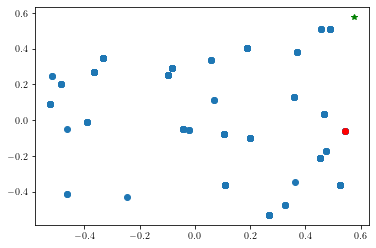

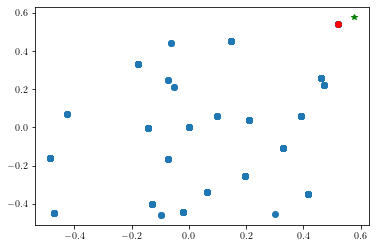

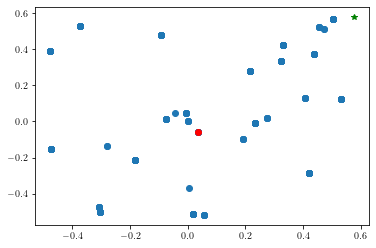

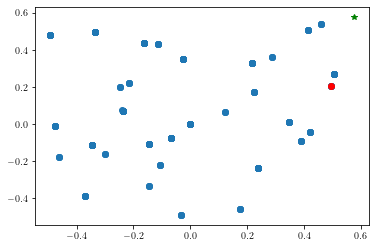

Finished


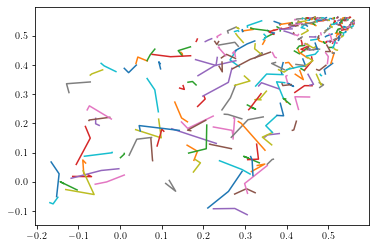

In [391]:
(errors_SO_d3, cons_SO_d3, gp, opt_d3) = run_exp_SafeOpt_LB_SGD(d=3, experiments_num=experiments_num, 
                                                                n_iters=200, n=n)
for i in range(experiments_num):
    opt_d3.errors_total[i] = np.repeat(opt_d3.errors_total[i], 2 * n)
    opt_d3.constraints_total[i] = np.repeat(opt_d3.constraints_total[i], 2 * n)

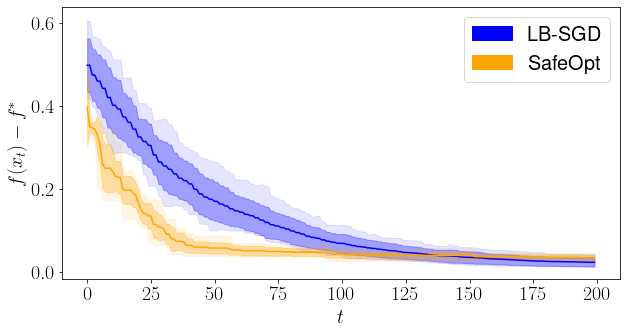

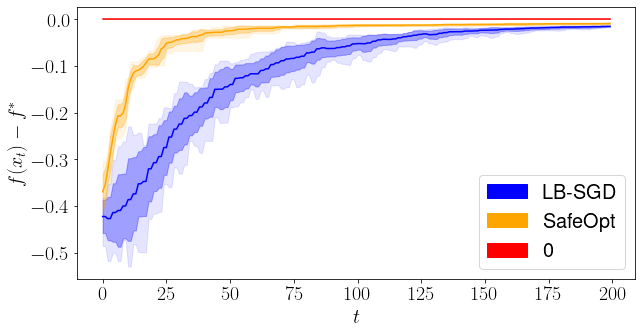

0

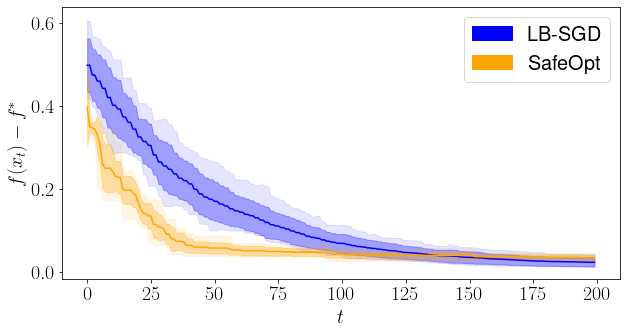

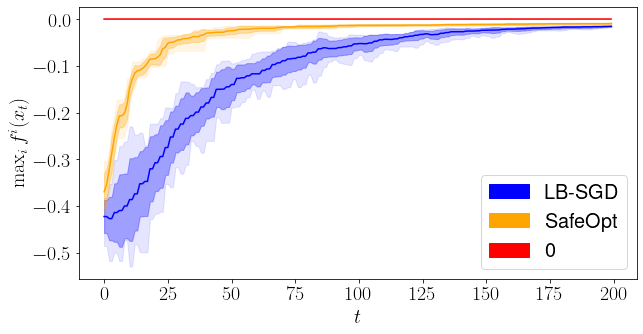

0

In [659]:
PlotConvergenceShaded([opt_d3.errors_total, errors_SO_d3], 
                      opt_d3.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d3",  m = "accuracy")

shape = np.shape(opt_d3.constraints_total)

PlotConvergenceShaded([opt_d3.constraints_total, cons_SO_d3, np.zeros(shape)], 
                      opt_d3.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d3",  m = "constraints")

In [396]:
d = 4
m = 2 * d 
x0 = np.ones(d) * 0.2
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
# n = int(d / 2)
n = 2
# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
#     xx[0] = 5.
    return np.linalg.norm(x - xx, 2)**2 / 4. / d 


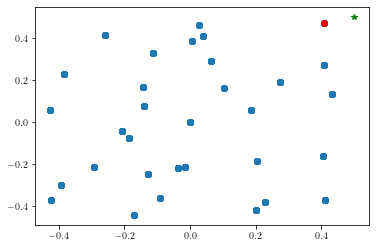

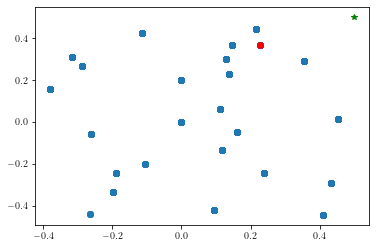

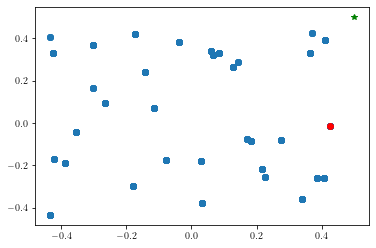

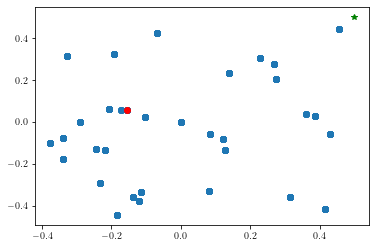

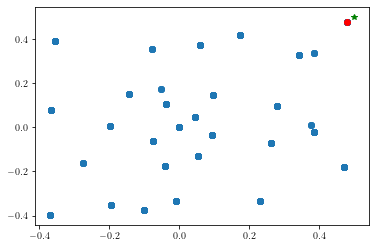

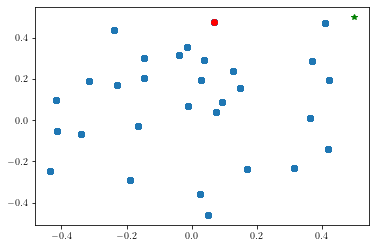

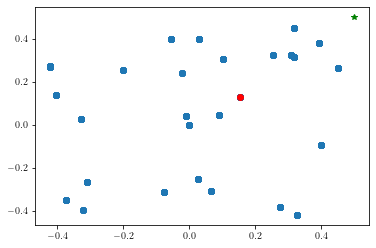

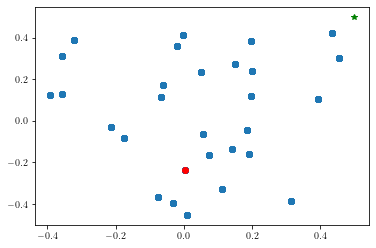

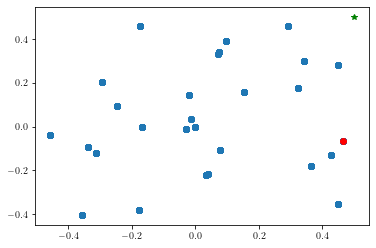

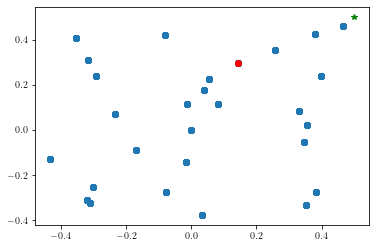

Finished


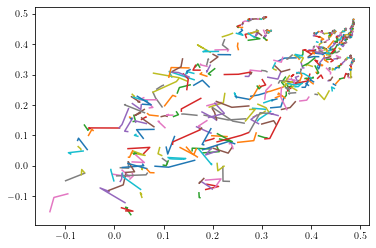

In [397]:
(errors_SO_d4, cons_SO_d4, gp, opt_d4) = run_exp_SafeOpt_LB_SGD(d=4, 
                                                                experiments_num=experiments_num, 
                                                                n_iters=400, 
                                                                n=n)
for i in range(experiments_num):
    opt_d4.errors_total[i] = np.repeat(opt_d4.errors_total[i], 2 * n)
    opt_d4.constraints_total[i] = np.repeat(opt_d4.constraints_total[i], 2 * n )

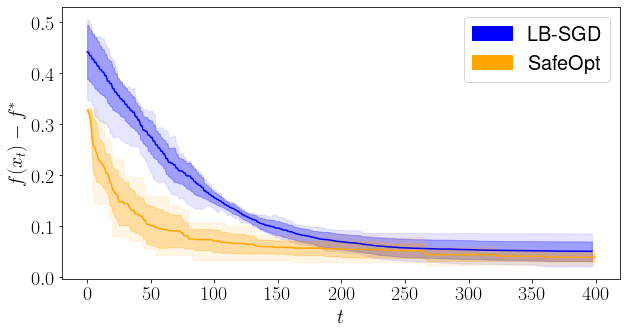

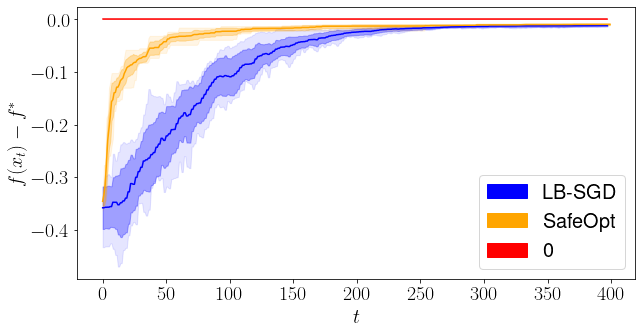

0

In [398]:
PlotConvergenceShaded([opt_d4.errors_total, errors_SO_d4], 
                      opt_d4.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d4_1",  m = "accuracy")

shape = np.shape(opt_d4.constraints_total)

PlotConvergenceShaded([opt_d4.constraints_total, cons_SO_d4, np.zeros(shape)], 
                      opt_d4.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d4_1",  m = "constraints")

In [53]:
d = 5
m = 2 * d 
x00 = np.zeros(d)
x_opt =  np.ones(d) / d**0.5
experiments_num = 10
n_iters = 350
# n = int(d / 2)
n = 3
# constraints
def h(x):
    d = np.size(x)
    A = np.vstack((np.eye(d),-np.eye(d)))
    b = np.ones(2 * d) / d**0.5
    return A.dot(x) - b 

# objective
def f(x):    
    d = np.size(x)
    xx = 2. * np.ones(d)
#     xx[0] = 5.
    return np.linalg.norm(x - xx, 2)**2 / 4. / d 

In [54]:
(errors_SO_d5, cons_SO_d5, gp, opt_d5) = run_exp_SafeOpt_LB_SGD(d=d, 
                                                                experiments_num=experiments_num, 
                                                                n_iters = n_iters, 
                                                                n = n, 
                                                                M0 = 0.1 / d, Ms = 0. * np.ones(m), 
                                                                x00 = np.zeros(d), 
                                                                x_opt =  np.ones(d) / d**0.5, 
                                                                f = f, h = h, 
                                                                sigma = 0.001, nu = 0.01, 
                                                                eta0 = 0.05, 
                                                                T = 3)
for i in range(experiments_num):
    opt_d5.errors_total[i] = np.repeat(opt_d5.errors_total[i], 2 * n)
    opt_d5.constraints_total[i] = np.repeat(opt_d5.constraints_total[i], 2 * n )

KeyboardInterrupt: 

In [ ]:
PlotConvergenceShaded([opt_d5.errors_total, errors_SO_d5], 
                      opt_d5.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d5",  m = "accuracy")

shape = np.shape(opt_d5.constraints_total)

PlotConvergenceShaded([opt_d5.constraints_total, cons_SO_d5, np.zeros(shape)], 
                      opt_d5.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d5",  m = "constraints")

Finished


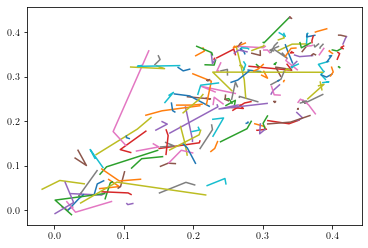

In [51]:
d = 5
m = 2 * d 
experiments_num = 10
n_iters = 300
x_opt = np.ones(d) / d**0.5
x0 = np.zeros(d)

n = 3
M0 = 0.05 / d
Ms = 0. * np.ones(m)
T = 3

my_oracle5 = LB.Oracle(
    f = f,
    h = h, 
    sigma = 0.001,
    hat_sigma = 0.01,
    delta = 0.01,
    m = m,
    d = d,
    nu = 0.01,
    zeroth_order = True,
    n = n)

opt5 = LB.SafeLogBarrierOptimizer(
    x00 = x0,
    x0 = x0,
    M0 = M0,
    Ms = Ms,
    sigma = my_oracle5.sigma,
    hat_sigma = my_oracle5.hat_sigma,
    init_std = 0.,
    eta0 = 0.05,
    oracle = my_oracle5,
    f = f,
    h = h,
    d = d,
    m = m,
    reg = 0.0001,
    x_opt = x_opt,
    factor = 0.85,
    T = T,
    K = int(n_iters / T / 2. / n),
#         factor = 0.5,
#         T = 100,
#         K = 4,
    experiments_num = experiments_num,
    mu = 0.,
    convex = True,
    random_init = True,
    no_break = True)

opt5.run_average_experiment()

for i in range(experiments_num):
    opt5.errors_total[i] = np.repeat(opt5.errors_total[i], 2 * n)
    opt5.constraints_total[i] = np.repeat(opt5.constraints_total[i], 2 * n )

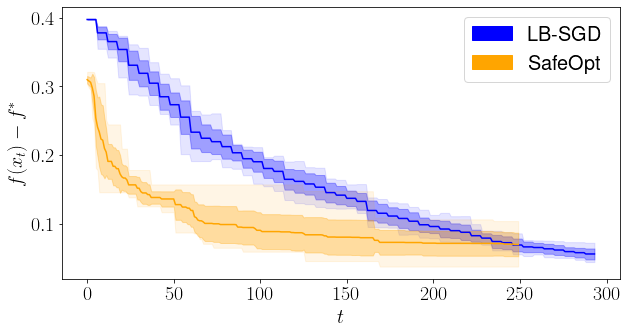

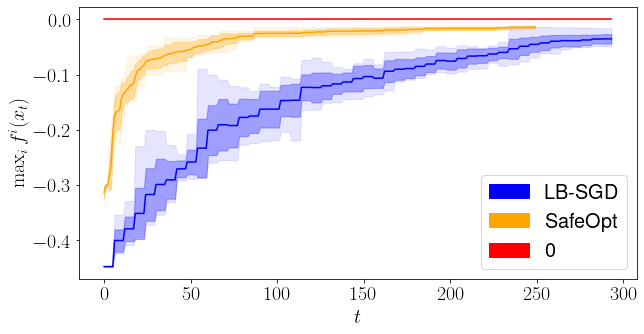

0

In [52]:
PlotConvergenceShaded([opt5.errors_total, errors_SO_d5], 
                      opt5.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d5",  m = "accuracy")

shape = np.shape(opt5.constraints_total)

PlotConvergenceShaded([opt5.constraints_total, cons_SO_d5, np.zeros(shape)], 
                      opt5.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d5",  m = "constraints")

Finished


array([0.47621496, 0.48297412, 0.46465997, 0.48672568])

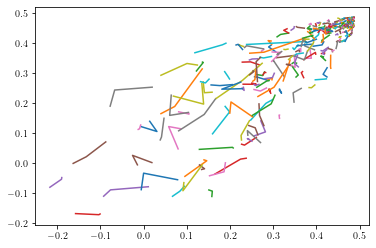

In [402]:
d = 4
m = 2 * d 
experiments_num = 10
n_iters = 400
x_opt = np.ones(d) / d**0.5
x0 = np.zeros(d)

n = 2
M0 = 0.5 / d
Ms = 0. * np.ones(m)
T = 3

my_oracle3 = LB.Oracle(
    f = f,
    h = h, 
    sigma = 0.001,
    hat_sigma = 0.01,
    delta = 0.01,
    m = m,
    d = d,
    nu = 0.01,
    zeroth_order = True,
    n = n)

opt3 = LB.SafeLogBarrierOptimizer(
    x00 = x0,
    x0 = x0,
    M0 = M0,
    Ms = Ms,
    sigma = my_oracle3.sigma,
    hat_sigma = my_oracle3.hat_sigma,
    init_std = 0.2,
    eta0 = 0.05,
    oracle = my_oracle3,
    f = f,
    h = h,
    d = d,
    m = m,
    reg = 0.0001,
    x_opt = x_opt,
    factor = 0.85,
    T = T,
    K = int(n_iters / T / 2. / n),
#         factor = 0.5,
#         T = 100,
#         K = 4,
    experiments_num = experiments_num,
    mu = 0.,
    convex = True,
    random_init = True,
    no_break = True)

opt3.run_average_experiment()

for i in range(experiments_num):
    opt3.errors_total[i] = np.repeat(opt3.errors_total[i], 2 * n)
    opt3.constraints_total[i] = np.repeat(opt3.constraints_total[i], 2 * n )

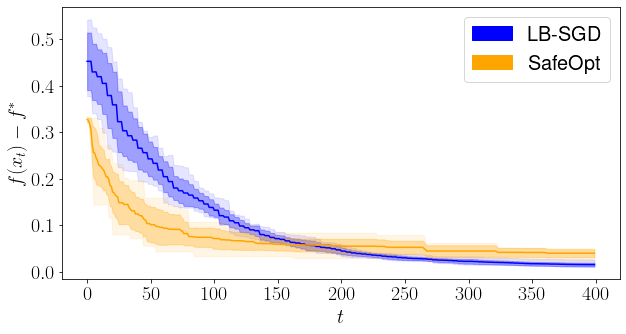

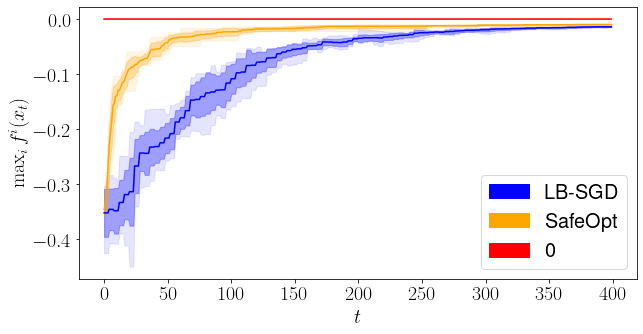

0

In [660]:
PlotConvergenceShaded([opt3.errors_total, errors_SO_d4], 
                      opt3.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_QP_d4",  m = "accuracy")

shape = np.shape(opt3.constraints_total)

PlotConvergenceShaded([opt3.constraints_total, cons_SO_d4, np.zeros(shape)], 
                      opt3.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_QP_d4",  m = "constraints")

## SafeOpt vs LB-SGD on non-linear non-convex problem with unimodal objective and constraints

In [120]:
# Rosenbrock fucntion

d = 2
m = 2
experiments_num = 10
n_iters = 100
n = 1

def f(x):
#     return np.sin(x[0]) * np.cos(x[1])
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 
#     return np.array([(x[0] + 0.1)**2 + (x[1] - 0.1)**2 - 0.2, x[0]**2 + x[1]**2 - 1.])
    


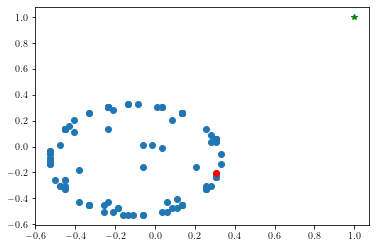

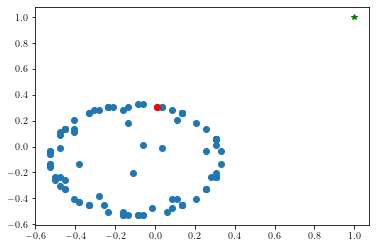

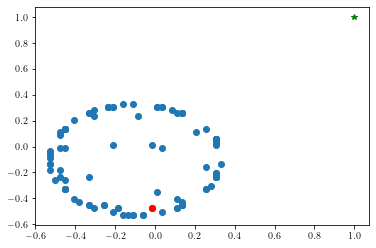

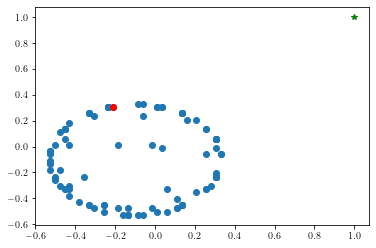

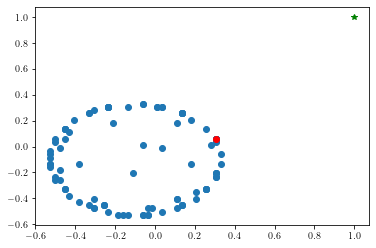

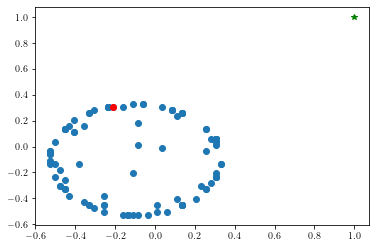

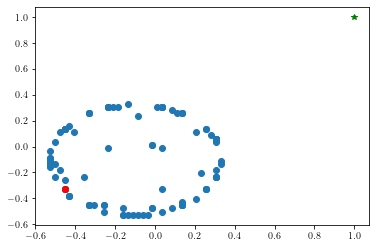

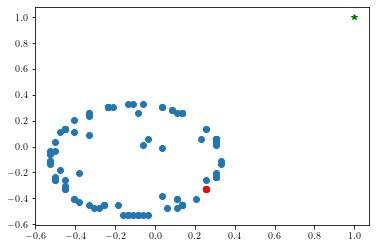

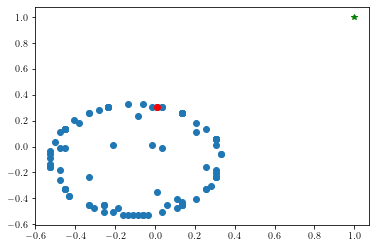

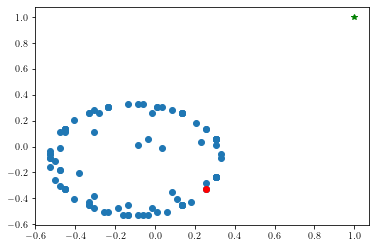

Finished


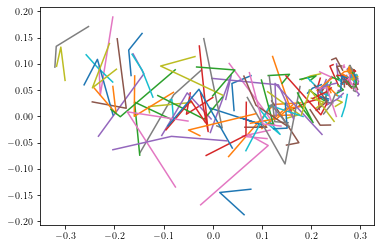

In [121]:
(errors_SO_r, cons_SO_r, gp_r, opt_r) = run_exp_SafeOpt_LB_SGD(d = d, 
                                                               experiments_num = experiments_num, 
                                                               n_iters = n_iters, 
                                                               n = n, 
                                                               M0 = 50., 
                                                               Ms = 5. * np.ones(m),
                                                               x00 = -0.05 * np.ones(d), 
                                                               x_opt = np.ones(d), 
                                                               sigma = 0.001,
                                                               nu = 0.01,
                                                               f = f, 
                                                               h = h)
for i in range(experiments_num):
    opt_r.errors_total[i] = np.repeat(opt_r.errors_total[i], 2 * n)
    opt_r.constraints_total[i] = np.repeat(opt_r.constraints_total[i], 2 * n)

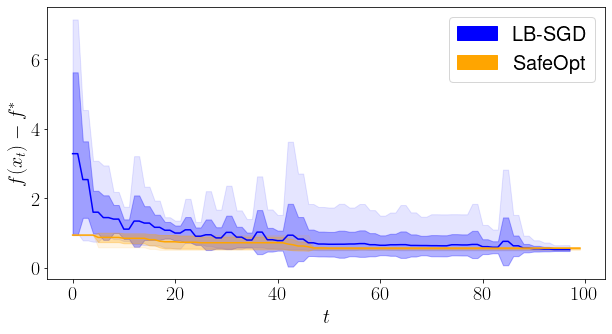

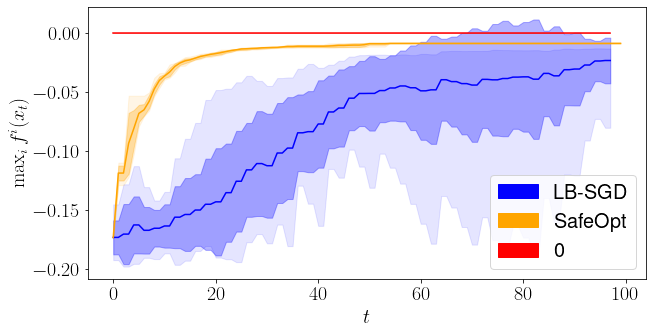

0

In [122]:
PlotConvergenceShaded([opt_r.errors_total, errors_SO_r], 
                      opt_r.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_rosenbrock",  m = "accuracy")

shape = np.shape(opt_r.constraints_total)

PlotConvergenceShaded([opt_r.constraints_total, cons_SO_r, np.zeros(shape)], 
                      opt_r.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_rosenbrock",  m = "constraints")

(<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x13c7699d0>,
 [<mpl_toolkits.mplot3d.art3d.Line3D at 0x13a097f70>])

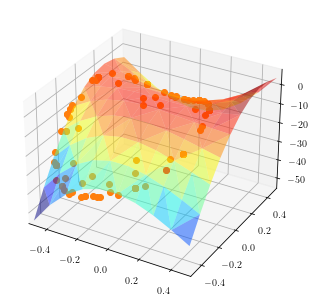

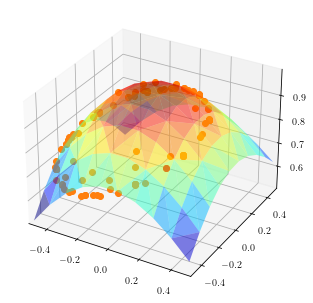

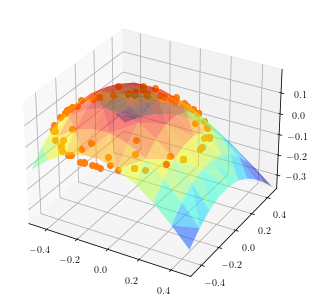

In [123]:
d = 2
bounds = []
for i in range(d):
    bounds.append([-0.5, 0.5])
        
inputs = linearly_spaced_combinations(
        bounds,
        num_samples=10)

plot_3d_gp(gp_r[0], inputs, predictions=None, figure=None, axis=None, fixed_inputs=None, beta=3)
plot_3d_gp(gp_r[1], inputs, predictions=None, figure=None, axis=None, fixed_inputs=None, beta=3)
plot_3d_gp(gp_r[2], inputs, predictions=None, figure=None, axis=None, fixed_inputs=None, beta=3)

In [105]:
# Rosenbrock fucntion d = 3

d = 3
m = 2
experiments_num = 10
n_iters = 150
n = 2

def f(x):
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2]) 

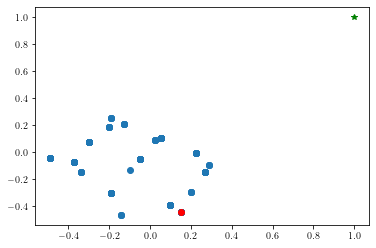

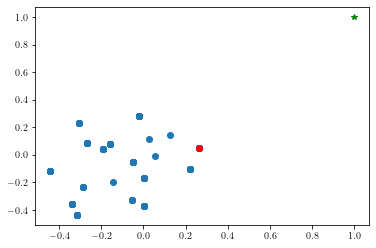

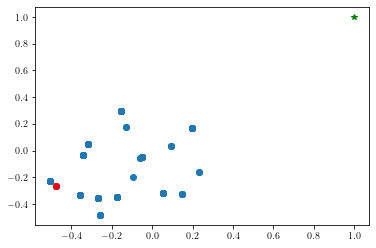

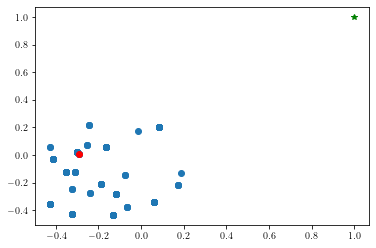

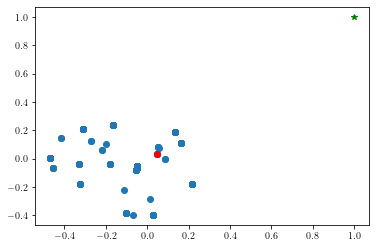

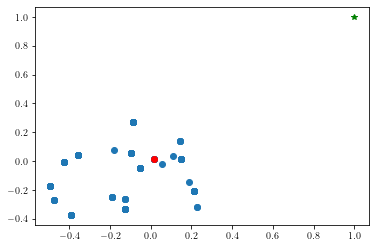

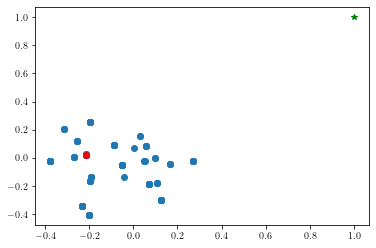

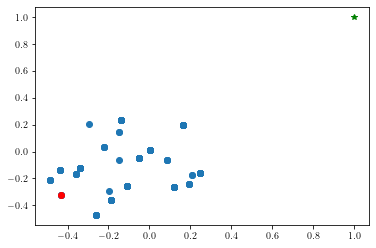

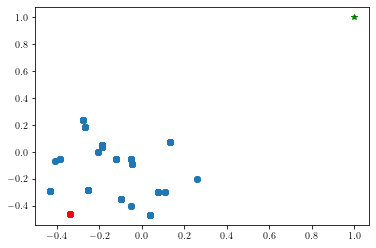

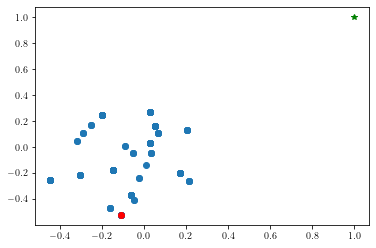

Finished


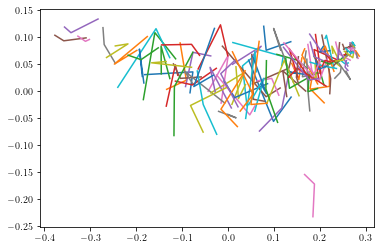

In [106]:
(errors_SO_r3, cons_SO_r3, gp_r3, opt_r3) = run_exp_SafeOpt_LB_SGD(d = d, 
                                                               experiments_num = experiments_num, 
                                                               n_iters = n_iters, 
                                                               n = n, 
                                                               M0 = 50., 
                                                               Ms = 5. * np.ones(m),
                                                               x00 = -0.05 * np.ones(d), 
                                                               x_opt = np.ones(d), 
                                                               sigma = 0.001,
                                                               nu = 0.01,
                                                               f = f, 
                                                               h = h)
for i in range(experiments_num):
    opt_r3.errors_total[i] = np.repeat(opt_r3.errors_total[i], 2 * n)
    opt_r3.constraints_total[i] = np.repeat(opt_r3.constraints_total[i], 2 * n)

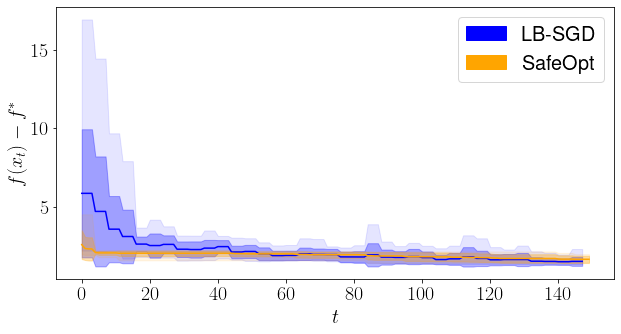

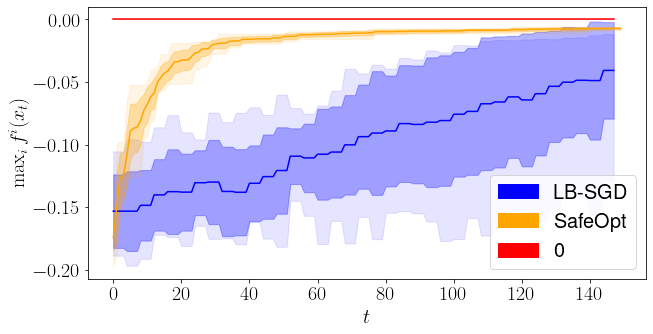

0

In [107]:
PlotConvergenceShaded([opt_r3.errors_total, errors_SO_r3], 
                      opt_r3.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_rosenbrock3",  m = "accuracy")

shape = np.shape(opt_r3.constraints_total)

PlotConvergenceShaded([opt_r3.constraints_total, cons_SO_r3, np.zeros(shape)], 
                      opt_r3.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_rosenbrock3",  m = "constraints")

In [111]:
# Rosenbrock fucntion d = 4
d = 4
m = 2
experiments_num = 10
n_iters = 150
n = 2

def f(x):
#     return np.sin(x[0]) * np.cos(x[1])
    f_rosenbrock = 0.
    for i in range(d - 1):
        f_rosenbrock += 100. * (x[i + 1] - x[i]**2)**2 + (1. - x[i])**2
    return f_rosenbrock

def h(x):
    h1 = np.linalg.norm(x,2)**2 - 1.
    h2 = np.linalg.norm(x + 0.1 * np.ones(d),2)**2 - 2. * 0.1
    return np.array([h1, h2])     

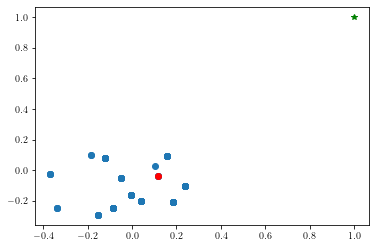

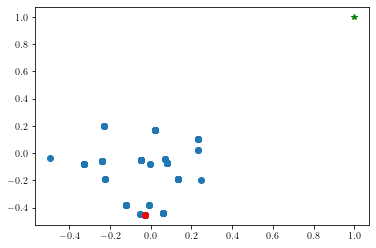

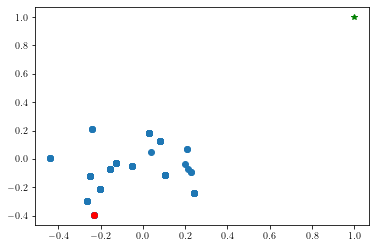

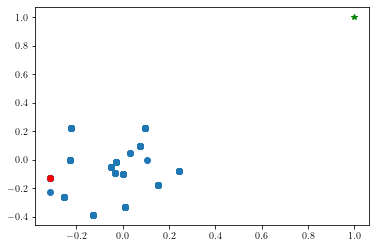

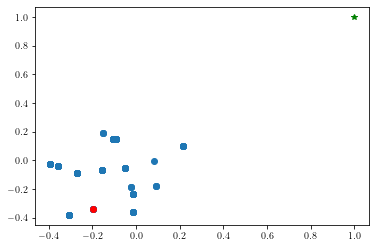

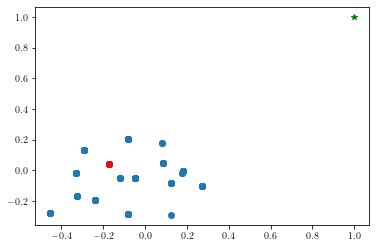

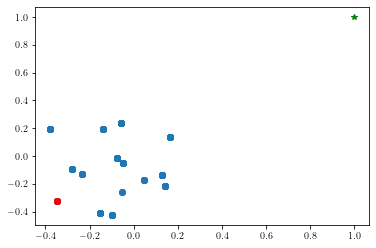

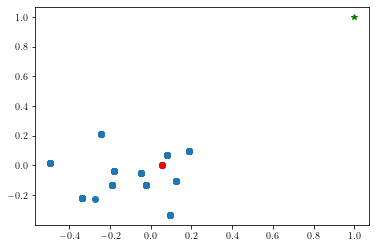

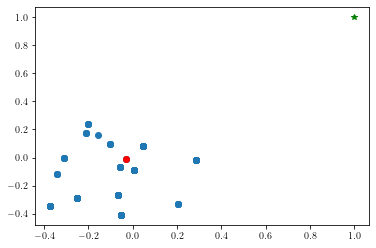

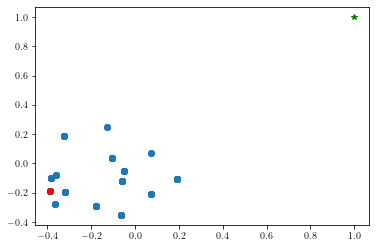

Finished


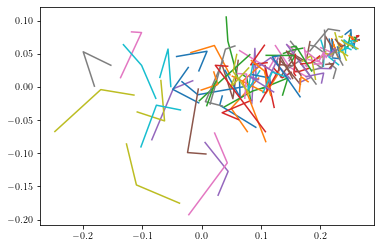

In [112]:
(errors_SO_r4, cons_SO_r4, gp_r4, opt_r4) = run_exp_SafeOpt_LB_SGD(d = d, 
                                                               experiments_num = experiments_num, 
                                                               n_iters = n_iters, 
                                                               n = n, 
                                                               M0 = 70., 
                                                               Ms = 7. * np.ones(m),
                                                               x00 = -0.05 * np.ones(d), 
                                                               x_opt = np.ones(d), 
                                                               sigma = 0.001,
                                                               nu = 0.01,
                                                               f = f, 
                                                               h = h)
for i in range(experiments_num):
    opt_r4.errors_total[i] = np.repeat(opt_r4.errors_total[i], 2 * n)
    opt_r4.constraints_total[i] = np.repeat(opt_r4.constraints_total[i], 2 * n)

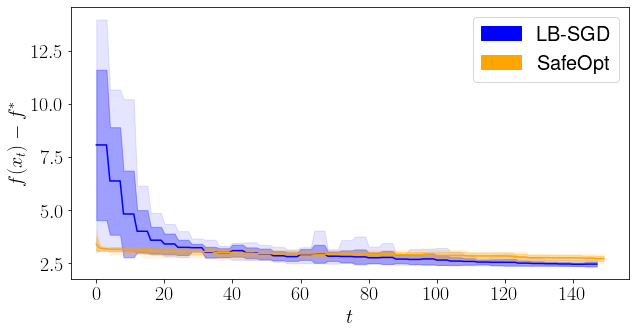

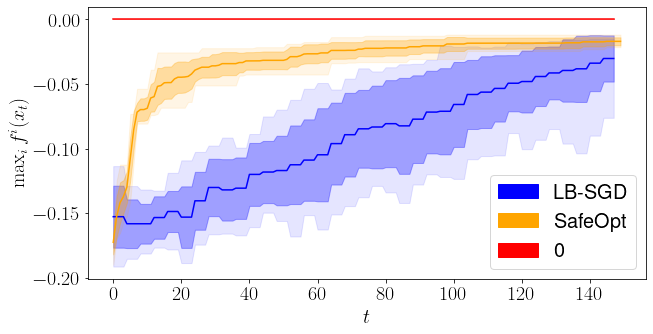

0

In [113]:
PlotConvergenceShaded([opt_r4.errors_total, errors_SO_r4], 
                      opt_r4.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "objective_rosenbrock4",  m = "accuracy")

shape = np.shape(opt_r4.constraints_total)

PlotConvergenceShaded([opt_r4.constraints_total, cons_SO_r4, np.zeros(shape)], 
                      opt_r4.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_rosenbrock4",  m = "constraints")

In [169]:
d = 6

x00 = np.array([0.1335990371483741, 0.2743781816448671, 0.2879962344461537,  0.10242147970254536, 0.3959197145814795, 0.5982863622683936])
x_opt = np.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652,  0.6573])
x00 = np.ones(d) * 0.5

L = 1.
M0 = 0.1
m = np.size(g(x00))
Ms = 0.1 * np.ones(m)
eta0 = 0.025
mu = 1

T = int(20 * d)
experiments_num = 20
num_samples = 1
sigma = 0.05
reg = 2
de = 0.01
nu = 0.01
K = 2
# S = int(10*d**0.5)
S = 1
V = 1

x00 = get_random_initial_point(g, x00)


NameError: name 'g' is not defined

In [185]:
# Hartmann and Hartmann
def f(x):
    return bench.hart6(x)
def h(x):
    return f(x) + 0.1
d = 6
m = 1
x_opt = np.array([0.20169, 0.150011, 0.476874, 
                  0.275332, 0.311652,  0.6573])
M0 = 5.
Ms = np.ones(m) * 5.
x0 = np.array([0.1335990371483741, 0.2743781816448671, 
               0.2879962344461537, 0.10242147970254536, 
               0.3959197145814795, 0.5982863622683936])
x0 = np.ones(d) * 0.2

#         if self.d == 6:
#             x0_det = np.array([0.1335990371483741, 0.2743781816448671, 
#                                0.2879962344461537, 0.10242147970254536, 
#                                0.3959197145814795, 0.5982863622683936])
#         else:
#             x0_det = 0.4 * np.ones(self.d)

# LineBO with constraint

## Gaussian 10 Quadratic Constraint

In [389]:
import h5py

In [390]:
def read_LineBO(file):
    ysss = []
    xsss = []
    ysss_min = []
    ysss_exact = []
    zsss_exact = []
    for j in range(3):
        xss = []
        yss = []
        yss_min = []
        yss_exact = []
        zss_exact = []
        for i in range(10):
            xs = []
            ys = []
            ys_min = []
            ys_exact = []
            zs_exact = []
            y_min = 10.
            for g in file[str(j)][str(i)]:
                xs.append(g['x'])
    #             print(g['x'], g['s'])
                ys.append(g['y'])
                ys_exact.append(g['y_exact'])
    #             zs_exact.append(g['z_exact'])
    #             for i in range(np.size(g['y_exact'])):
    #             print(y_min)
    #             print(g['y_exact'])
                y_min = min(-g['y_exact'], y_min)
                ys_min.append(y_min)

            xs = np.array(xs)
            ys = np.array(ys)
            ys_exact = np.array(ys_exact)
            ys_min = np.array(ys_min)
    #         zs_exact = np.array(zs_exact)
            xss.append(xs)
            yss.append(ys)
            yss_exact.append(ys_exact)
            yss_min.append(ys_min)
    #         zss_exact.append(zs_exact)

        yss = np.array(yss)
        xss = np.array(xss)
        yss_exact = np.array(yss_exact)
        yss_min = np.array(yss_min)
    #     zss_exact = np.array(zss_exact)

        ysss_exact.append(yss_exact)
        ysss_min.append(yss_min)
        xsss.append(xss)
    #     zsss_exact.append(zss_exact)
    return (ysss_exact, ysss_min, xsss)

In [ ]:
file = h5py.File('/Users/ilnura/libs/LineBO/runs/Gaussian_2_constraint/data/evaluations.hdf5', 'r')
(ysss_exact, ysss_min, xsss) = read_LineBO(file)

LB_SGD runs finished


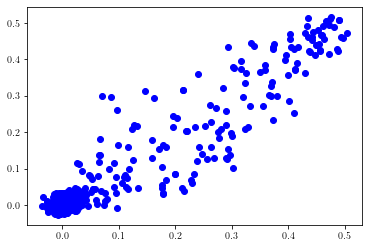

In [394]:
d = 2
m = 2 
experiments_num = 10
n_iters = d * 100
# n_iters = 200
x_opt = np.zeros(d) / d**0.5
x0 = d**(-1) * np.ones(d)
# x0 = d**(-0.5) * np.ones(d)
# x0[0] = 0.

n = int(d / 2)
M0 = 30.
Ms = d**2 * 0.5 * np.ones(m)
T = 3

"""
Gaussian benchmark function with quadratic constraint.
"""
def h(X):
    r = d**(-0.5)
    x0 = d**(-0.5) * np.ones(d)
    h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
    return np.array([h - 20. , h - 10.])
 
def f(X):
#     X = np.atleast_2d(X)
#     Y = np.exp(-4 * np.sum(np.square(X), axis=1))
    Y = np.exp(-4 * np.linalg.norm(X,2)**2)
    return -Y


my_oracle3 = LB.Oracle(
    f = f,
    h = h, 
    sigma = 0.001,
    hat_sigma = 0.01,
    delta = 0.01,
    m = m,
    d = d,
    nu = 0.01,
    zeroth_order = True,
    n = n)

opt3 = LB.SafeLogBarrierOptimizer(
    x00 = x0,
    x0 = x0,
    M0 = M0,
    Ms = Ms,
    sigma = my_oracle3.sigma,
    hat_sigma = my_oracle3.hat_sigma,
    init_std = 0.,
    eta0 = 0.1,
    oracle = my_oracle3,
    f = f,
    h = h,
    d = d,
    m = m,
    reg = 0.0001,
    x_opt = x_opt,
    factor = 0.9,
    T = T,
    K = int(n_iters / T / 2. / n),
    experiments_num = experiments_num,
    mu = 0.,
    convex = True,
    random_init = True,
    no_break = True)

opt3.run_average_experiment()

for i in range(experiments_num):
    opt3.errors_total[i] = np.repeat(opt3.errors_total[i], 2 * n)
    opt3.constraints_total[i] = np.repeat(opt3.constraints_total[i], 2 * n )

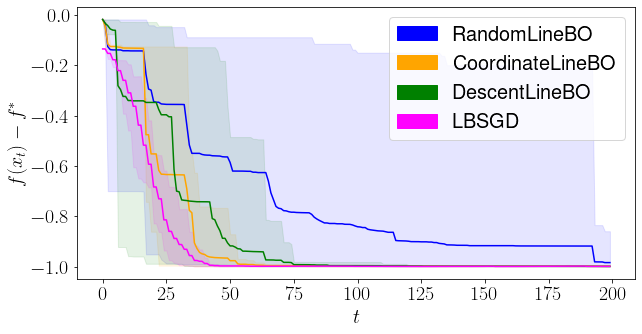

0

In [395]:
shape = np.shape(opt3.errors_total)
PlotConvergenceShaded([ysss_min[0]
                       ,ysss_min[1]
                       ,ysss_min[2]
                       ,opt3.errors_total - np.ones(shape)
#                        ,np.zeros(shape)
                      ], 
                      10, 
                      colors=['blue' 
                              ,'orange'
                              ,'green'
                              ,'magenta'
                             ], 
                      legends=['RandomLineBO' 
                               ,'CoordinateLineBO' 
                               ,'DescentLineBO'
                               ,'LBSGD'
                              ],
                      figsize=(10, 5),
                      fname = "obj_linebo",  m = "accuracy")

In [274]:
x = [-0.13353719, -0.13773307] 
# [-4.17728314]
def h(X):
    d = np.size(X)
    r = d**(-0.5)
    x0 = d**(-0.5) * np.ones(d)
    h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
    return -h

print(h(x))

-3.7754541570568283


In [266]:
# x = [-0.00334448, -0.00196135, 
#      -0.0027389,  -0.00073295,
#      0.0011308,   0.00050727,
#      -0.00146265,  0.0006341,  
#      -0.00091564, -0.00027287]

# def h(X):
#     r = d**(-0.5)
#     x0 = d**(-0.5) * np.ones(d)
#     h = np.linalg.norm(X - x0)**2 - r**2 + d**2 * (X[1] - x0[1])**2
#     return np.array([h])
# h(x)

In [267]:
# PlotConvergenceShaded([-ysss_exact[0]
#                        ,-ysss_exact[1]
#                        ,-ysss_exact[2]
# #                        ,-ysss_exact[3]
#                       ], 
#                       10, 
#                       colors=['blue' 
#                               ,'orange'
#                               ,'green'
#                              ], 
#                       legends=['RandomLineBO' 
#                                ,'CoordinateLineBO' 
#                                ,'DescentLineBO' 
#                               ],
#                       figsize=(10, 5),
#                       fname = "obj_linebo",  m = "accuracy")

In [38]:


# def __init__(self, path=None):
#     super().__init__(path)
#     ones = np.ones(self.config.dimension)

#     self._dist_initial = np.sqrt(np.log(1 / self.config.initial_value) / 4)
#     self._x0 = self._dist_initial * ones / np.sqrt(self.config.dimension)
#     self._max_value = 1.0
#     self._domain = ContinuousDomain(-ones, ones)

# def _get_random_initial_point(self):
#     dir = np.random.normal(size=self.config.dimension)
#     return self._dist_initial * dir / np.linalg.norm(dir)



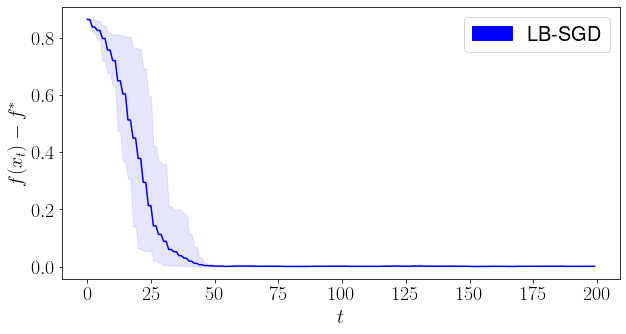

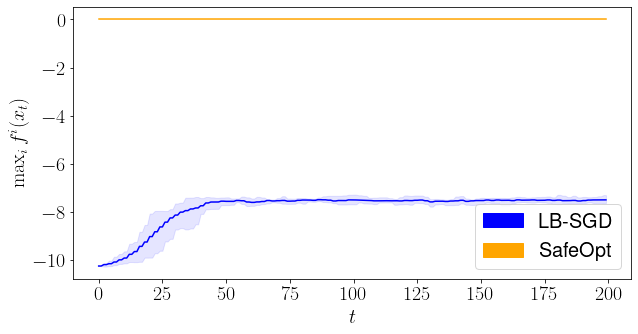

0

In [301]:
PlotConvergenceShaded([opt3.errors_total], 
                      opt3.experiments_num, 
                      colors=['blue', 'orange'], 
                      legends=['LB-SGD', 'SafeOpt'],
                      figsize=(10, 5),
                      fname = "Objective_Gaussian_d10",  m = "accuracy")

shape = np.shape(opt3.constraints_total)

PlotConvergenceShaded([opt3.constraints_total, np.zeros(shape)], 
                      opt3.experiments_num, 
                      colors=['blue', 'orange', 'red'], 
                      legends=['LB-SGD', 'SafeOpt', '0'],
                      figsize=(10, 5),
                      fname = "constraints_Gaussian_d10",  m = "constraints")

In [1]:
import sys
sys.path = ['/Users/ilnura/libs/LineBO'] + sys.path
from febo.main import initialize_framework, run, create
import argparse

In [2]:
# initialize_framework(default_config='/Users/ilnura/libs/LineBO/default.yaml')

Recieved setting data for unregistered section main.
Registered module "MultiExperiment".
Registered module "SimpleExperiment".
Registered module "SequentialController".
Registered module "RepetitionController".
Registered module "SimpleController".
Registered module "PlottingController".
Registered module "UCB".
Registered module "Algorithm".
Registered module "Rembo".
Registered module "InterleavedRembo".
Registered module "SPSA".
Registered module "CMAES".
Registered module "SafeOpt".
Registered module "SubDomainBO".
Registered module "SafeOptConfigMixin".
Registered module "NelderMead".
Registered module "BenchmarkEnvironment".
Registered module "Gaussian".
Registered module "AugmentedDimensionMixinConfig".
Registered module "GridSolver".
Registered module "ScipySolver".
Registered module "GP".
Registered module "ScipySolver".
Recieved setting data for unregistered section main.


In [3]:
parser = argparse.ArgumentParser(description='Bandit and Bayesian Optimization Experimental Framework.')
parser.add_argument("experiment", nargs='?', default='Gaussian_constraint')
parser.add_argument("--config", required=False, default=None)
sys.argv = ['', '--config=/Users/ilnura/libs/LineBO/config/gaussian_10_constraint.yaml']
args = parser.parse_args()
args

Namespace(experiment='Gaussian_constraint', config='/Users/ilnura/libs/LineBO/config/gaussian_10_constraint.yaml')

In [197]:
parser = argparse.ArgumentParser(description='Bandit and Bayesian Optimization Experimental Framework.')
parser.add_argument("experiment", nargs='?', default='hartmann6_constraint')
parser.add_argument("--config", required=False, default=None)
sys.argv = ['', '--config=/Users/ilnura/libs/LineBO/config/hartmann6_constraint.yaml']

In [198]:
args = parser.parse_args()
args

Namespace(experiment='hartmann6_constraint', config='/Users/ilnura/libs/LineBO/config/hartmann6_constraint.yaml')

In [199]:
create(args)

Recieved setting data for unregistered section main.


AttributeError: 'Namespace' object has no attribute 'overwrite'

In [200]:
run(args, '/Users/ilnura/libs/LineBO')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ilnura/libs/LineBO/runs/hartmann6_constraint/experiment.yaml'

In [4]:
ls /Users/ilnura/libs/LineBO/runs

camelback/                       hartmann6_constrained_quad3_big/
hartmann6_constrained_by_quad1/  hartmann6_constraint1/
hartmann6_constrained_by_quad2/


In [5]:
create(args)
run(args, '/Users/ilnura/libs/LineBO')

Recieved setting data for unregistered section environment.benchmark.gaussianConstraint.
Recieved setting data for unregistered section main.


AttributeError: 'Namespace' object has no attribute 'overwrite'

In [6]:
args

Namespace(experiment='Gaussian_constraint', config='/Users/ilnura/libs/LineBO/config/gaussian_10_constraint.yaml')

In [7]:
ls /Users/ilnura/libs/LineBO

config/        dist/          febo.egg-info/ runs/
default.yaml   febo/          readme.md      setup.py
